In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pairwise maximum entropy: Dutch parliament as an Ising ferromagnet

## Importing and processing

Data van tweede kamer verkiezingen na 2008:

- 9 juni 2010
- 12 september 2012
- 15 maart 2017
- 17 maart 2021
- 22 november 2023

Zoek opdracht voor moties over een bepaalde periode:

In [2]:
# Periode kabinet Rutte II
search_query = "?$filter=Verwijderd eq false and Vergissing eq false and ((year(GewijzigdOp) eq 2012 and month(GewijzigdOp) ge 10) or (year(GewijzigdOp) ge 2013 and year(GewijzigdOp) le 2016) or (year(GewijzigdOp) eq 2017 and month(GewijzigdOp) le 2)) & orderby=GewijzigdOp"

In [3]:
url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Stemming{search_query}"
response = requests.get(url)
data = response.json()
data;

Moties tijdens kabinet Rutte II:

In [4]:
# Define the initial URL
url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Stemming{search_query}"

# Initialize an empty list to store all the data points
all_data = []

# Loop to fetch all pages of data
while url:
    # Make an HTTP GET request to the current URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Convert the JSON response to a Python dictionary
        data = response.json()
        
        # Extract the 'value' part of the JSON response and append it to the list
        all_data.extend(data['value'])
        
        # Check if there's a next page link
        if '@odata.nextLink' in data:
            # Update the URL to fetch the next page of data
            url = data['@odata.nextLink']
        else:
            # If there's no next page link, exit the loop
            url = None
    else:
        # If the request was not successful, print an error message and exit the loop
        print("Error:", response.status_code)
        url = None

# Convert the list of data points to a Pandas DataFrame
df = pd.DataFrame(all_data).sort_values(by='GewijzigdOp')

# Raw data array containing most motions during Rutte III. 
df


,Id,Besluit_Id,Soort,FractieGrootte,ActorNaam,ActorFractie,Vergissing,SidActorLid,SidActorFractie,Persoon_Id,Fractie_Id,GewijzigdOp,ApiGewijzigdOp,Verwijderd
0,76829575-3085-4c4f-b00e-2b4a256c7261,57e214d1-785a-4094-b9c9-348c6d587464,Voor,2,50PLUS,50PLUS,False,None,S-1-365867521-2120874753-800324394-1119149088-...,None,a34bf6c8-834e-4dba-b4d2-f2f1b3957bd2,2012-10-03T12:05:11.583+02:00,2019-07-26T11:41:08.4939605Z,False
1,cddf6f2f-1468-4497-9e1b-a3d2c11dacca,57e214d1-785a-4094-b9c9-348c6d587464,Voor,13,CDA,CDA,False,None,S-1-365867521-2120874753-3726368973-1295802169...,None,62c1a13c-85ff-40ed-90f7-a9546d61f869,2012-10-03T12:05:11.647+02:00,2019-07-26T12:58:51.0343326Z,False
2,feb332aa-aa11-4757-a50c-83edc9fc9c0c,57e214d1-785a-4094-b9c9-348c6d587464,Voor,5,ChristenUnie,ChristenUnie,False,None,S-1-365867521-2120874753-1996180723-1207380569...,None,d720f5af-0516-408a-b830-0b6ffb8a581c,2012-10-03T12:05:11.693+02:00,2019-07-26T13:03:34.3473918Z,False
3,006f83b4-640c-4989-975c-e2cef8d46214,57e214d1-785a-4094-b9c9-348c6d587464,Voor,12,D66,D66,False,None,S-1-365867521-2120874753-1399399692-1206643224...,None,4e9f6f5b-2544-4667-8134-6b85c4ebb4e0,2012-10-03T12:05:11.723+02:00,2019-07-26T13:03:11.0973372Z,False
4,00f20afa-94e2-49eb-bcf8-6b67cff1d6b9,57e214d1-785a-4094-b9c9-348c6d587464,Voor,4,GroenLinks,GroenLinks,False,None,S-1-365867521-2120874753-2386850707-1282307975...,None,8fd1a907-0355-4d27-8dc1-fd5a531b471e,2012-10-03T12:05:11.74+02:00,2019-07-26T13:04:08.4880753Z,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10181,cc485534-6391-40fd-9680-6659897cc302,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,Voor,3,SGP,SGP,False,None,S-1-365867521-2120874753-1520352372-1191064225...,None,77f9b6f1-b1a9-4d1b-a05e-9936e79d8fa5,2017-02-24T12:18:15.947+01:00,2019-07-26T13:04:50.4256557Z,False
10180,79f0eefe-31d7-4f80-999e-1a159f9a71dd,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,Voor,2,PvdD,PvdD,False,None,S-1-365867521-2120874753-3375217526-1184288014...,None,d3b4d880-ef37-4ce6-99ec-4940266ac466,2017-02-24T12:18:15.947+01:00,2019-07-26T12:59:20.331261Z,False
10182,442a8b4a-0ff7-4d2a-9747-934f1e3aa31f,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,Tegen,12,PVV,PVV,False,None,S-1-365867521-2120874753-203711267-1259409971-...,None,65129918-f256-4975-9da4-488da34d6695,2017-02-24T12:18:15.947+01:00,2019-07-19T11:51:22.7312487Z,False
10183,ac2f2db1-e1d4-4d45-9e34-728aee3f6afb,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,Voor,1,Van Vliet,Van Vliet,False,None,S-1-365867521-2120874753-2382917585-1146149961...,None,e2c3dd23-f247-430a-9c94-53f9f5c06c0b,2017-02-24T12:18:15.96+01:00,2019-07-26T12:55:59.4871186Z,False


Hoeveel moties waren er?

In [7]:
df['Besluit_Id'].nunique()

636

Partijen:

In [8]:
parties = df['ActorFractie'].unique()
parties

array(['50PLUS', 'CDA', 'ChristenUnie', 'D66', 'GroenLinks', 'PvdD',
       'PvdA', 'PVV', 'SGP', 'SP', 'VVD', 'Bontes', 'Van Vliet',
       'Van Klaveren', 'GrBvK', '50PLUS/Baay-Timmerman', '50PLUS/Klein',
       'Klein', 'GrKÖ', 'Houwers', 'Monasch'], dtype=object)

We negeren de ondestaande afgesplinterde partijen (in haakjes hun originele partij):
- Bontes (PVV)
- Van Vliet (PVV) (sloot zich niet aan bij de tweede kamer fractie van de VVD in 2018)
- Klein (50Plus)
- Houwers (VVD)
- 50PLUS/Klein (50Plus)
- 50PLUS/Baay-Timmerman (50Plus)
- Van Klaveren (PVV)
- GrBvK (PVV)
- GrKÖ (PvdA)

Ik haal ook 50PLUS eruit want die partij viel uit elkaar.


In [9]:
filtered_parties = np.array(['PVV', 'PvdD', 'SP', 'GroenLinks', 'D66', 'ChristenUnie', 'SGP', 'CDA', 'PvdA','VVD'])
filtered_parties_short = np.array(['PVV','PvdD','SP', 'GL', 'D66', 'CU', 'SGP', 'CDA', 'PvdA','VVD'])

Process the dataframe:

In [10]:
# Remove ignored parties
processed_df = df[df['ActorFractie'].isin(filtered_parties)]

# Only keep cases where ActorNaam == ActorFractie, i.e. vote cast as a party
processed_df = processed_df[processed_df['ActorNaam'] == processed_df['ActorFractie']]

# Keep only relevant columns 
processed_df = processed_df[['Besluit_Id','Soort', 'ActorFractie']]

# Replace votes with numerical values
processed_df['Soort'] = processed_df['Soort'].map({'Voor': 1, 'Tegen': -1, 'Niet deelgenomen':0})
processed_df = processed_df.reset_index(drop=True)

processed_df

,Besluit_Id,Soort,ActorFractie
0,57e214d1-785a-4094-b9c9-348c6d587464,1,CDA
1,57e214d1-785a-4094-b9c9-348c6d587464,1,ChristenUnie
2,57e214d1-785a-4094-b9c9-348c6d587464,1,D66
3,57e214d1-785a-4094-b9c9-348c6d587464,1,GroenLinks
4,57e214d1-785a-4094-b9c9-348c6d587464,1,PvdD
...,...,...,...
6255,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,PvdA
6256,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,SGP
6257,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,PvdD
6258,c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,PVV


In [11]:
fractiegroottes = df.groupby('ActorFractie')['FractieGrootte'].unique()
fractiegroottes = fractiegroottes.apply(lambda x: x[0])
fractiegroottes = fractiegroottes[fractiegroottes.index.isin(filtered_parties)]

fractiegroottes = fractiegroottes.loc[filtered_parties]
fractiegroottes

ActorFractie
PVV             15
PvdD             2
SP              15
GroenLinks       4
D66             12
ChristenUnie     5
SGP              3
CDA             13
PvdA            38
VVD             41
Name: FractieGrootte, dtype: int64

## Asymmetric dataset

In [12]:
pivot_df = processed_df.pivot(index='Besluit_Id', columns='ActorFractie', values='Soort').fillna(0)
pivot_df = pivot_df[filtered_parties] # sorting columns
pivot_df

ActorFractie,PVV,PvdD,SP,GroenLinks,D66,ChristenUnie,SGP,CDA,PvdA,VVD
Besluit_Id,,,,,,,,,,
0001864e-d3c6-4624-a93f-a0f8dd4c04cc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
011086ac-713f-455c-bd37-22591ad5ceb4,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01eb5f6c-1a76-4c13-bdb1-c8d7eb9e6ca7,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02257872-4505-4fcc-b545-6ae5f15efefd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02435d6f-a53b-4791-91ce-3f1d098e7f1b,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
fec0ce7a-dfcd-43b0-a1b2-69d8ea1341b6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
fefa9414-00c9-4e33-bb3c-0baeafe18863,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ff078a51-edeb-4146-8580-a212222ed2f4,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


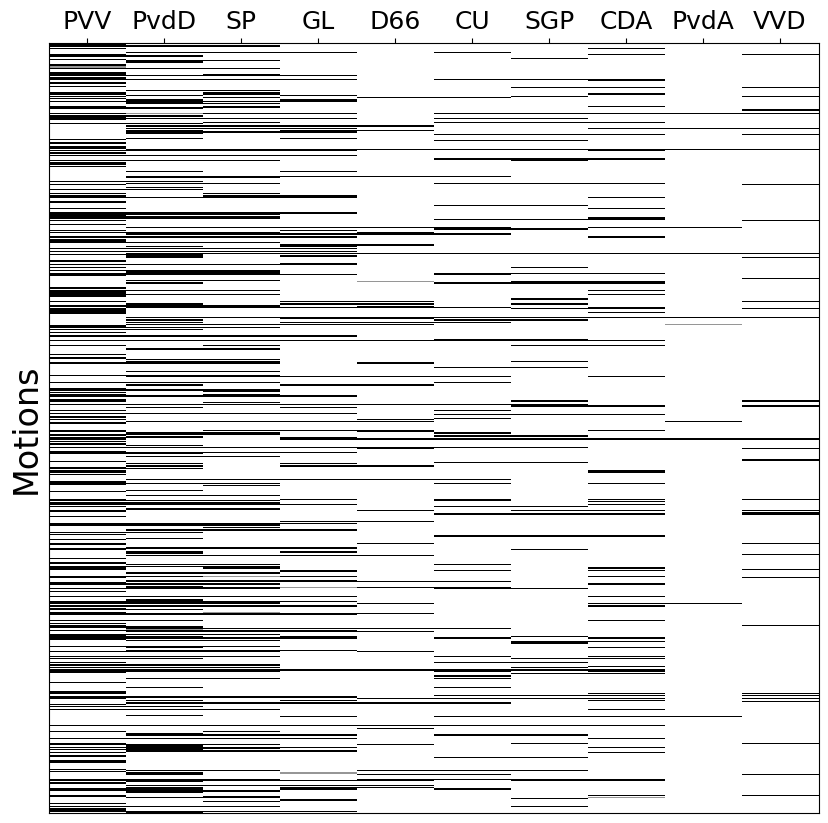

In [13]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(pivot_df, interpolation='none', cmap='Greys_r', extent=[0,10,0,10])
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=18); 
ax.set_yticks([]);
ax.set_ylabel('Motions', fontsize=24)
ax.xaxis.tick_top()


Gemiddelde stem per fractie: 

In [14]:
mean_votes = processed_df.groupby('ActorFractie')['Soort'].mean().reset_index()
mean_votes.columns = ['ActorFractie', 'Mean Vote']
mean_votes

,ActorFractie,Mean Vote
0,CDA,0.750799
1,ChristenUnie,0.770335
2,D66,0.824281
3,GroenLinks,0.680000
4,PVV,0.277955
5,PvdA,0.968051
6,PvdD,0.382400
7,SGP,0.789474
8,SP,0.513600
9,VVD,0.881978


In [15]:
correlation_matrix = pivot_df.corr()
correlation_matrix

ActorFractie,PVV,PvdD,SP,GroenLinks,D66,ChristenUnie,SGP,CDA,PvdA,VVD
ActorFractie,,,,,,,,,,
PVV,1.000000,0.226289,0.300301,0.113461,0.022881,-0.000100,0.066679,0.207652,-0.020791,0.079450
PvdD,0.226289,1.000000,0.690908,0.521069,0.290696,0.240943,0.079735,0.174870,0.129568,-0.072586
SP,0.300301,0.690908,1.000000,0.450338,0.294948,0.261819,0.095732,0.257350,0.174325,-0.063623
GroenLinks,0.113461,0.521069,0.450338,1.000000,0.438607,0.257984,0.090298,0.228607,0.268062,0.037668
D66,0.022881,0.290696,0.294948,0.438607,1.000000,0.328862,0.177140,0.162752,0.291779,0.160637
ChristenUnie,-0.000100,0.240943,0.261819,0.257984,0.328862,1.000000,0.544780,0.348081,0.228673,0.143321
SGP,0.066679,0.079735,0.095732,0.090298,0.177140,0.544780,1.000000,0.389159,0.200681,0.266969
CDA,0.207652,0.174870,0.257350,0.228607,0.162752,0.348081,0.389159,1.000000,0.292728,0.273882
PvdA,-0.020791,0.129568,0.174325,0.268062,0.291779,0.228673,0.200681,0.292728,1.000000,0.287287


Correlaties:

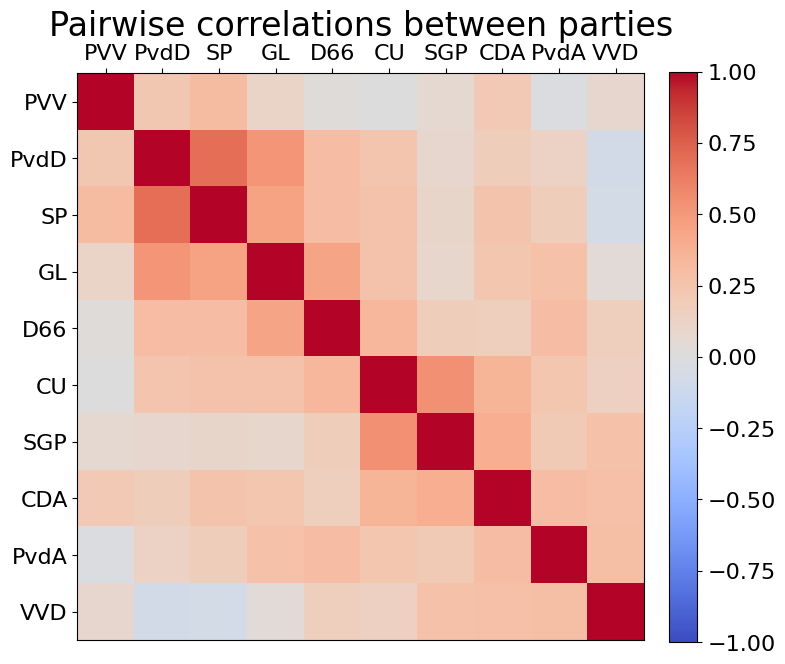

In [27]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=+1, extent=[0,10,0,10])
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16)
ax.set_title('Pairwise correlations between parties', fontsize=24)
ax.xaxis.tick_top()

## Symmetrised dataset

Maak de dataset symmetrisch. ("Voor" or "Tegen" heeft een arbitraire definitie.)

In [17]:
# Copy the DataFrame and flip the values in the 'Soort' column
sym_df = processed_df.copy()
sym_df['Soort'] = sym_df['Soort'].map({1: -1, -1: 1})

# Add a prefix to the 'Besluit_Id' column in the symmetrized DataFrame
sym_df['Besluit_Id'] = 'sym_' + sym_df['Besluit_Id'].astype(str)

# Concatenate the original DataFrame with the symmetrized one
sym_df = pd.concat([processed_df, sym_df], ignore_index=True)

sym_df

,Besluit_Id,Soort,ActorFractie
0,57e214d1-785a-4094-b9c9-348c6d587464,1,CDA
1,57e214d1-785a-4094-b9c9-348c6d587464,1,ChristenUnie
2,57e214d1-785a-4094-b9c9-348c6d587464,1,D66
3,57e214d1-785a-4094-b9c9-348c6d587464,1,GroenLinks
4,57e214d1-785a-4094-b9c9-348c6d587464,1,PvdD
...,...,...,...
12515,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,PvdA
12516,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,SGP
12517,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,-1,PvdD
12518,sym_c5eed118-3f54-4a2f-b3b1-e2014cf2d102,1,PVV


In [18]:
sym_mean_votes = sym_df.groupby('ActorFractie')['Soort'].mean().reset_index()
sym_mean_votes.columns = ['ActorFractie', 'Mean Vote']
sym_mean_votes

,ActorFractie,Mean Vote
0,CDA,0.0
1,ChristenUnie,0.0
2,D66,0.0
3,GroenLinks,0.0
4,PVV,0.0
5,PvdA,0.0
6,PvdD,0.0
7,SGP,0.0
8,SP,0.0
9,VVD,0.0


In [19]:
sym_pivot_df = sym_df.pivot(index='Besluit_Id', columns='ActorFractie', values='Soort').fillna(0)
sym_pivot_df = sym_pivot_df[filtered_parties] # sorting columns
sym_pivot_df; 

In [20]:
sym_correlation_matrix = sym_pivot_df.corr()
sym_correlation_matrix

ActorFractie,PVV,PvdD,SP,GroenLinks,D66,ChristenUnie,SGP,CDA,PvdA,VVD
ActorFractie,,,,,,,,,,
PVV,1.000000,0.306955,0.390088,0.268585,0.241214,0.213887,0.258579,0.340256,0.263578,0.280926
PvdD,0.306955,1.000000,0.744000,0.612800,0.466827,0.436103,0.346646,0.393285,0.399680,0.305112
SP,0.390088,0.744000,1.000000,0.632000,0.565947,0.538339,0.455272,0.530776,0.533973,0.426518
GroenLinks,0.268585,0.612800,0.632000,1.000000,0.741807,0.643771,0.576678,0.620304,0.706635,0.611822
D66,0.241214,0.466827,0.565947,0.741807,1.000000,0.753392,0.711892,0.678914,0.838658,0.769354
ChristenUnie,0.213887,0.436103,0.538339,0.643771,0.753392,1.000000,0.821372,0.724661,0.782123,0.722488
SGP,0.258579,0.346646,0.455272,0.576678,0.711892,0.821372,1.000000,0.750200,0.794893,0.773525
CDA,0.340256,0.393285,0.530776,0.620304,0.678914,0.724661,0.750200,1.000000,0.774760,0.747007
PvdA,0.263578,0.399680,0.533973,0.706635,0.838658,0.782123,0.794893,0.774760,1.000000,0.887470


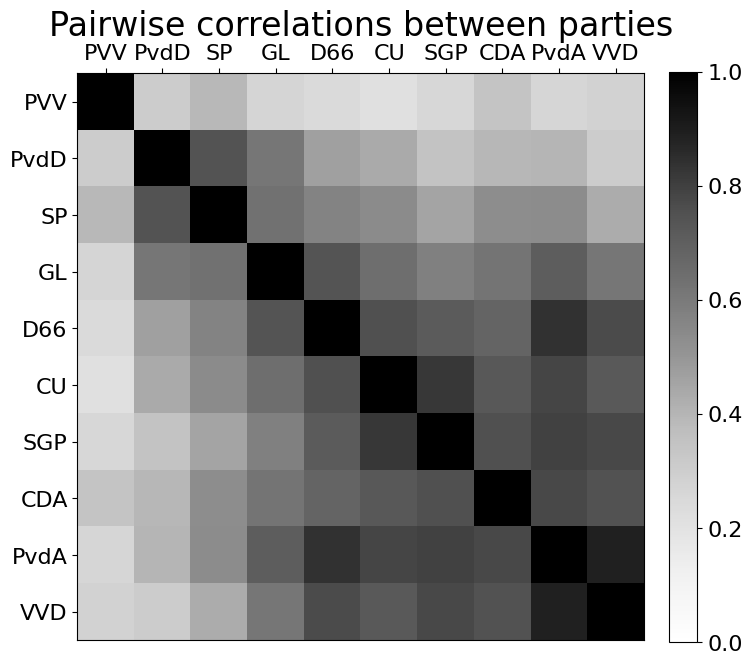

In [28]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(sym_correlation_matrix, cmap='Greys', vmin=0, vmax=+1, extent=[0,10,0,10])
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16)
ax.set_title('Pairwise correlations between parties', fontsize=24)
ax.xaxis.tick_top()

## Solving the inverse problem (symmetrised data)

The joint probability distribution for the string of votes $\{\sigma_i\}$ is given by:
\begin{align*}
p(\{\sigma_i\}) = \frac{1}{Z(J)} \exp\bigg(-\frac{1}{2} E(\{\sigma_i\}, J)\bigg),
\end{align*}
where the energy function is given by:
\begin{align*}
E(\{\sigma_i\}, J) = - \sum_{ij} J_{ij} \sigma_i \sigma_j.
\end{align*}
The partition function is:
\begin{align*}
Z(J) = \sum_{\{\sigma_i\}} \exp\bigg(-\frac{1}{2} E(\{\sigma_i\}, J)\bigg).
\end{align*}


We would like to solve the 45 simultaneous equations for the elements of $J$:
$$
f_{ab}(J) = \langle \sigma_a \sigma_b \rangle_{\mathrm{exp}} - \sum_{\{\sigma_i\}} \sigma_a \sigma_b \, p(\{\sigma_i\}) = 0,
$$
where the first term is the pairwise correlation in the data. Our task at hand is to find the roots of $f_{ab}(J)$. Note that we are not $\textit{fitting}$ a model to the data. We are writing down a model that assumes the most structureless joint probability distribution that reproduces (exactly) the pairwise correlations. 

To help us numerically, we will need the Jacobian:
$$
\begin{split}
2\frac{\partial f_{ab} (J) }{\partial J_{ij}} &= - 2\sum_{\{\sigma_i\}} \sigma_a \sigma_b \, \frac{\partial p(\{\sigma_i\})}{\partial J_{ij}} \\
&= - \sum_{\{\sigma_i\}} \sigma_a \sigma_b \, (\sigma_i \sigma_j - \langle \sigma_i \sigma_j \rangle ) \, p (\{ \sigma_i \}) \\
&= -\langle \sigma_a \sigma_b \sigma_i \sigma_j \rangle + \langle \sigma_a \sigma_b \rangle \langle \sigma_i \sigma_j \rangle
\end{split}
$$

To find the roots we use a simple implementation of gradient descent.


In [31]:
# function that takes a decimal number and returns a binary vector of given length
def decimal_to_binary_vector(decimal_number, vector_length):
    binary_string = bin(decimal_number)[2:]  # Convert decimal number to binary string
    binary_vector = [int(bit) for bit in binary_string]  # Convert binary string to binary vector
    
    # Add leading zeros to the binary vector
    while len(binary_vector) < vector_length:
        binary_vector.insert(0, 0)

    # Replace 0s with -1s in the binary vector
    binary_vector = [-1 if bit == 0 else bit for bit in binary_vector]

    return binary_vector

# all possible spin configurations
spins = np.array([decimal_to_binary_vector(i, 10) for i in range(2**10)])


In [32]:
# energy
def E(sigma, J): 
    energy = -(1/2)*np.dot(sigma, np.matmul(J, sigma))
    return energy

In [33]:
# probability distribution and partition function
def pspins(J):
    pspins = np.zeros(2**10)
    for i, sigma in enumerate(spins):
        pspins[i] = -0.5*E(sigma, J)
    Z = np.sum(np.exp(pspins))
    return Z, np.exp(pspins)/Z

In [34]:
# pairwise correlation matrix
def corr2(pvec):
    corr = 0
    for k, sigma in enumerate(spins):
        corr += np.outer(sigma, sigma)*pvec[k]
    return corr

In [35]:
# matrix J to vector representation
def J_to_vec(J):
    n = J.shape[0]
    vec = []
    for i in range(n):
        for j in range(i+1, n):
            vec.append(J[i, j])
    return vec

# vector to matrix J representation
def vec_to_J(vec):
    n = int((1 + np.sqrt(1 + 8 * len(vec))) / 2)  # Calculate the size of the matrix from the number of off-diagonal elements
    J = np.zeros((n, n))  # Initialize the interaction matrix with zeros

    # Fill the off-diagonal elements
    k = 0
    for i in range(n):
        for j in range(i + 1, n):
            J[i][j] = vec[k]
            J[j][i] = vec[k]
            k += 1

    return J

In [36]:
# Function we would like to find the root of
def G(pvec):
    return J_to_vec(sym_correlation_matrix.to_numpy() - corr2(pvec))

# Objective function
def obj(pvec):
    return np.linalg.norm(G(pvec))**2

# Jacobian
def jac(pvec):

    jac = 0

    for k, sigma in enumerate(spins):
        jac -= np.outer(J_to_vec(np.outer(sigma,sigma)), J_to_vec(np.outer(sigma, sigma)))*pvec[k]
    
    two_point_corr = corr2(pvec)

    jac += np.outer(J_to_vec(two_point_corr), J_to_vec(two_point_corr))

    return jac

In [37]:
#J = np.zeros((10, 10))

# hard-coded solution to gradient descent to save time
J = np.array([
    [0.0, 0.18103645, 0.6621292, -0.11809289, -0.24379373, -0.33185336, 0.09678797, 0.58694602, -0.0313452, 0.25401599],
    [0.18103645, 0.0, 1.5873513, 0.96367733, 0.2750523, 0.24179055, -0.27701321, -0.0205276, -0.12505997, -0.59172182],
    [0.6621292, 1.5873513, 0.0, 0.55883767, 0.3605971, 0.37530026, -0.04958895, 0.370947, 0.15771971, -0.29238315],
    [-0.11809289, 0.96367733, 0.55883767, 0.0, 0.88374831, 0.26495584, -0.04779242, 0.17592821, 0.57391919, 0.17063458],
    [-0.24379373, 0.2750523, 0.3605971, 0.88374831, 0.0, 0.43549782, 0.26162873, 0.07431799, 0.95277687, 0.67937067],
    [-0.33185336, 0.24179055, 0.37530026, 0.26495584, 0.43549782, 0.0, 1.05205001, 0.41355788, 0.52784383, 0.31427012],
    [0.09678797, -0.27701321, -0.04958895, -0.04779242, 0.26162873, 1.05205001, 0.0, 0.67799106, 0.68344025, 0.6953807],
    [0.58694602, -0.0205276, 0.370947, 0.17592821, 0.07431799, 0.41355788, 0.67799106, 0.0, 0.60784214, 0.63526891],
    [-0.0313452, -0.12505997, 0.15771971, 0.57391919, 0.95277687, 0.52784383, 0.68344025, 0.60784214, 0.0, 1.32683575],
    [0.25401599, -0.59172182, -0.29238315, 0.17063458, 0.67937067, 0.31427012, 0.6953807, 0.63526891, 1.32683575, 0.0]
])

Z, pvec = pspins(J)
obj(pvec)

np.float64(0.009033777222778708)

In [38]:
it = 100
i = 0

while i < it:
    J = vec_to_J(J_to_vec(J) - 0.01*np.linalg.matmul(jac(pvec).T, G(pvec)))
    Z, pvec = pspins(J)
    i += 1

print(obj(pvec))

0.008880427259805085


Our solution for $J$ reproduces the correlation matrix from the data:

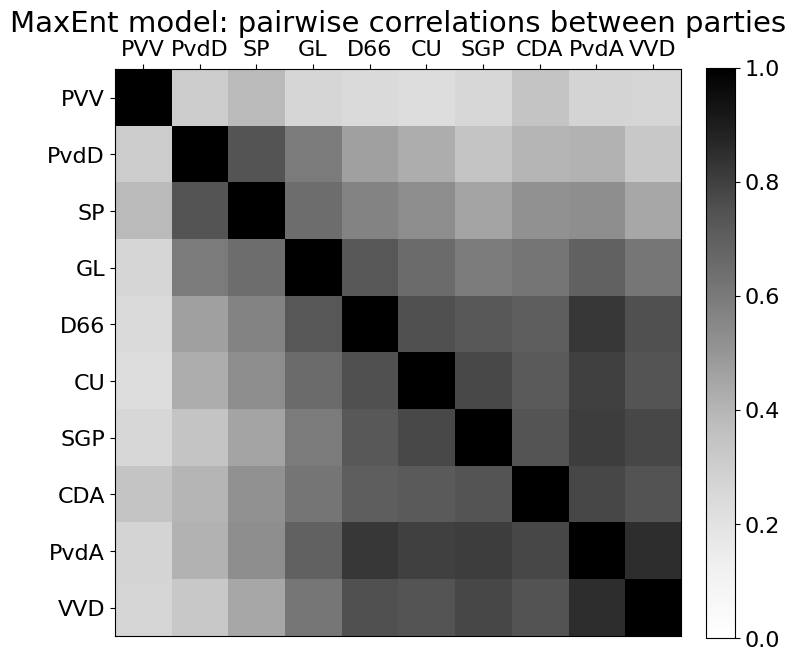

In [41]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(corr2(pvec), cmap='Grays', vmin=0, vmax=+1, extent=[0,10,0,10])
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16)
ax.set_title('MaxEnt model: pairwise correlations between parties', fontsize=21)
ax.xaxis.tick_top()

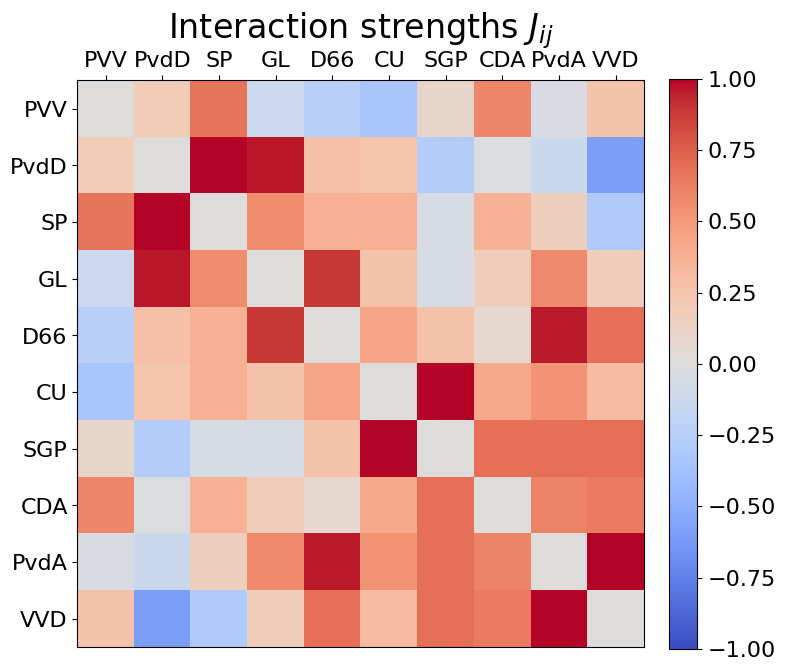

In [44]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(J, cmap='coolwarm', vmin=-1, vmax=+1, extent=[0,10,0,10])
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)
ax.set_xticks(np.linspace(0.5, 9.5, 10))
ax.set_yticks(np.linspace(9.5, 0.5, 10))
ax.set_xticklabels(filtered_parties_short, fontsize=16)
ax.set_yticklabels(filtered_parties_short, fontsize=16)
ax.set_title(r'Interaction strengths $J_{ij}$', fontsize=24)
ax.xaxis.tick_top()

## Energy landscape

In [33]:
max_index = np.argmax(pvec)
max_value = pvec[max_index]

max_index, max_value

(np.int64(0), np.float64(0.18541749392177984))

In [34]:
top_indices = np.argsort(pvec)[-6:]
top_values = pvec[top_indices]

top_indices, top_values

(array([ 127,  896,  512,  511,    0, 1023]),
 array([0.02137455, 0.02137455, 0.06445248, 0.06445248, 0.18541749,
        0.18541749]))

In [35]:
print(J)

[[ 0.          0.17853963  0.66644941 -0.11487134 -0.24723342 -0.34138045
   0.09779005  0.58866046 -0.03355091  0.26227841]
 [ 0.17853963  0.          1.59095263  0.97350191  0.27475013  0.24997761
  -0.27486126 -0.02252513 -0.12958351 -0.60449339]
 [ 0.66644941  1.59095263  0.          0.55041381  0.35886408  0.38419826
  -0.04557049  0.37798391  0.15698555 -0.30092539]
 [-0.11487134  0.97350191  0.55041381  0.          0.89609068  0.25777134
  -0.05851684  0.1748458   0.58266966  0.17284923]
 [-0.24723342  0.27475013  0.35886408  0.89609068  0.          0.43155737
   0.25199118  0.06316052  0.96740407  0.69101332]
 [-0.34138045  0.24997761  0.38419826  0.25777134  0.43155737  0.
   1.08193089  0.41960135  0.51812223  0.30396211]
 [ 0.09779005 -0.27486126 -0.04557049 -0.05851684  0.25199118  1.08193089
   0.          0.68643956  0.67320591  0.68829637]
 [ 0.58866046 -0.02252513  0.37798391  0.1748458   0.06316052  0.41960135
   0.68643956  0.          0.60521527  0.63740297]
 [-0.033

## Attaching ideological labels

In [63]:
besluit_id = "57e214d1-785a-4094-b9c9-348c6d587464"

url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Besluit({besluit_id})"
response = requests.get(url)

if response.status_code == 200:
    besluit_data = response.json()
    print(besluit_data)
else:
    print(f"Error fetching besluit with id {besluit_id}: {response.status_code}")

{'@odata.context': 'https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/$metadata#Besluit/$entity', 'Id': '57e214d1-785a-4094-b9c9-348c6d587464', 'Agendapunt_Id': '66502fe7-a38f-4bb1-b3f3-60644f595be7', 'StemmingsSoort': 'Met handopsteken', 'BesluitSoort': 'Stemmen - aangenomen', 'BesluitTekst': 'Aangenomen', 'Opmerking': None, 'Status': 'Besluit', 'AgendapuntZaakBesluitVolgorde': 2, 'GewijzigdOp': '2012-10-02T16:06:59.923+02:00', 'ApiGewijzigdOp': '2019-06-29T03:09:05.6001882Z', 'Verwijderd': False}


In [80]:
# Stel je AgendapuntId in
agendapunt_id = "66502fe7-a38f-4bb1-b3f3-60644f595be7"  # Het AgendapuntId dat je hebt

# Stel de query op om documenten te filteren op het AgendapuntId
search_query = f"?$filter=Agendapunt/Id eq '{agendapunt_id}'"

# Bouw de URL voor het Document endpoint
url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Document{search_query}"

# Doe het verzoek
response = requests.get(url)

# Controleer de statuscode en verwerk het antwoord
if response.status_code == 200:
    document_data = response.json()
    print(document_data)
else:
    print(f"Error fetching documents for AgendapuntId {agendapunt_id}: {response.status_code}")


Error fetching documents for AgendapuntId 66502fe7-a38f-4bb1-b3f3-60644f595be7: 400


In [79]:
agendapunt_id = "66502fe7-a38f-4bb1-b3f3-60644f595be7"  # Het AgendapuntId uit jouw besluit
url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Agendapunt({agendapunt_id})"
response = requests.get(url)

if response.status_code == 200:
    agendapunt_data = response.json()
    print(agendapunt_data)
else:
    print(f"Error fetching agendapunt with id {agendapunt_id}: {response.status_code}")


{'@odata.context': 'https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/$metadata#Agendapunt/$entity', 'Id': '66502fe7-a38f-4bb1-b3f3-60644f595be7', 'Nummer': '2012P14177', 'Onderwerp': 'Wijziging van de Wet op het financieel toezicht, het Burgerlijk Wetboek, de Wet op de economische delicten en enige fiscale wetten ter implementatie van richtlijn nr. 2011/61/EU van het Europees Parlement en de Raad van de Europese Unie van 8 juni 2011 inzake beheerders van alternatieve beleggingsinstellingen en tot wijziging van de Richtlijnen 2003/41/EG en 2009/65/EG en van de Verordeningen (EG) Nr. 1060/2009 en (EU) Nr. 1095/2010 (PbEU 2011, L 174)', 'Aanvangstijd': None, 'Eindtijd': None, 'Volgorde': 1, 'Rubriek': None, 'Noot': None, 'Status': 'Vrijgegeven', 'GewijzigdOp': '2019-10-21T10:14:33.597+02:00', 'ApiGewijzigdOp': '2019-10-21T09:06:12.7151208Z', 'Verwijderd': False, 'Activiteit_Id': '3073c37e-bb30-4a3b-b381-d0ccc6f96a10'}


In [42]:
# Voorbeeld om document-id op te halen
document_ids = df['Besluit_Id'].unique()

# Voorbeeld van een query om details van een motie/document op te halen
for doc_id in document_ids[:2]:
    url = f"https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/Document({doc_id})"
    response = requests.get(url)
    
    if response.status_code == 200:
        document_data = response.json()
        # Print of verwerk de inhoud van het document
        print(document_data['Titel'], document_data['DocumentTekst'])
    else:
        print(f"Error fetching document with id {doc_id}: {response.status_code}")


Error fetching document with id 57e214d1-785a-4094-b9c9-348c6d587464: 404
Error fetching document with id 7fd1b9db-74a1-48b5-8ede-993b3b7fb491: 404
